In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from keras.datasets import imdb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

class LSTMWithGloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional=False):
        super(LSTMWithGloVe, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1]  
        return self.sigmoid(self.fc(hidden.squeeze(0)))  


In [3]:
embedding_dim = 300
embedding_index = {}
with open(f'glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [4]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in imdb.get_word_index().items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [7]:
hidden_dim = 64  
output_dim = 1  
num_layers = 2  
bidirectional = False  


model = LSTMWithGloVe(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional).to(device)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
print(X_train)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence


X_train_padded = pad_sequence([torch.tensor(sequence) for sequence in X_train], batch_first=True)
X_test_padded = pad_sequence([torch.tensor(sequence) for sequence in X_test], batch_first=True)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_padded, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_padded, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch [1/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [2/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [3/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [4/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [5/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [6/10], Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch [7/10], Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch [8/10], Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch [9/10], Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch [10/10], Test Loss: 0.6931, Test Accuracy: 50.00%


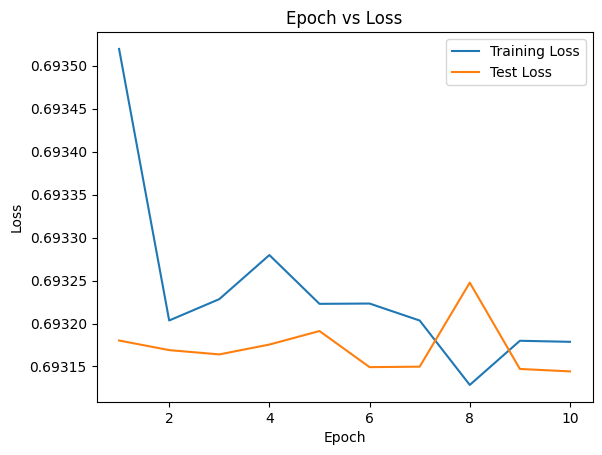

In [10]:
import matplotlib.pyplot as plt

n_epochs = 10
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs.flatten(), labels)
            test_loss += loss.item()
            predicted = (outputs > 0.5).squeeze().long()
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{n_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {100 * correct / total:.2f}%')


plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()
